# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import warnings

import numpy             as np
import pandas            as pd
import scipy.stats       as ss

import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display         import Image
from IPython.core.display    import HTML

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing   import StandardScaler, MinMaxScaler

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression

from boruta                  import BorutaPy

from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve


# costomized packages
import sys
sys.path.append('../')

from src.data.make_dataset   import Dataset

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('seaborn-bright')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
#========================================== Statistical Summary ==========================================#
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T
    iqr = pd.DataFrame(q75.reset_index(drop=True) - q25.reset_index(drop=True))

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = q25.reset_index(drop=True) - 1.5 * iqr.reset_index(drop=True)
    high_outliers = q75.reset_index(drop=True) + 1.5 * iqr.reset_index(drop=True)


    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q25, q75, q95, iqr, low_outliers, high_outliers, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '25%', '75%', '95%','IQR', 'Low Outliers', 'High Outliers', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m



#========================================== Cramer V (Correlation) ==========================================#
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

## 0.3 Loading data

In [5]:
dataset = Dataset()

### 0.3.1 Saving Test Dataset

In [6]:
#dataset.get_test_data('../zip')

### 0.3.2 Query Train Dataset

In [7]:
df_raw = dataset.get_train_data("../query/raw_data.sql")

### 0.3.3 Saving the Data

In [8]:
#Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# Convert to .Feather Data
# train_dataset.to_feather('../data/interim/training_data.feather')
# test_dataset.to_feather('../data/interim/test_data.feather')

### 0.3.4 Read Training Dataset

In [9]:
df_train = pd.read_feather('../data/interim/training_data.feather')

# 1.0 Data Description

In [10]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,217244,Female,41,47.0,152.0,1,1-2 Year,No,1,2630.0,34,0
1,62034,Female,23,36.0,152.0,1,< 1 Year,No,1,34188.0,30,0
2,290598,Male,71,28.0,26.0,1,1-2 Year,Yes,0,52749.0,91,0
3,213946,Male,43,26.0,124.0,1,1-2 Year,Yes,0,25326.0,230,0
4,209186,Male,58,8.0,124.0,1,1-2 Year,No,1,2630.0,116,0


## 1.1 Data Dimensions

In [11]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 323942
Number of Columns: 12


## 1.2 Data Type

In [12]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [13]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 ~~Change Data type~~

## 1.5 Check Balanced Data

In [14]:
df01['response'].value_counts(normalize=True)

0    0.877438
1    0.122562
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [15]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [16]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,25%,75%,95%,IQR,Low Outliers,High Outliers,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.826274,36.0,21.0,25.0,49.0,69.0,24.0,-11.0,85.0,15.517508,0.399665,0.673293,-0.565892
1,region_code,0.0,52.0,52.0,28.0,26.393033,28.0,5.0,15.0,35.0,47.0,20.0,-15.0,65.0,13.228600,0.501216,-0.115215,-0.867152
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.020346,132.0,26.0,29.0,152.0,160.0,123.0,-155.5,336.5,54.211038,0.483939,-0.899422,-0.971961
3,driving_license,0.0,1.0,1.0,1.0,0.997898,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.045802,0.045898,-21.741487,470.695147
4,previously_insured,0.0,1.0,1.0,0.0,0.457983,0.0,0.0,0.0,1.0,1.0,1.0,-1.5,2.5,0.498231,1.087881,0.168664,-1.971564
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30544.875234,31667.0,2630.0,24380.0,39406.0,55139.0,15026.0,1841.0,61945.0,17206.737636,0.563326,1.765382,34.531512
6,vintage,10.0,299.0,289.0,73.0,154.375379,154.0,24.0,82.0,227.0,285.0,145.0,-135.5,444.5,83.647592,0.541845,0.002887,-1.199693
7,response,0.0,1.0,1.0,0.0,0.122562,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.327934,2.675655,2.301926,3.298883


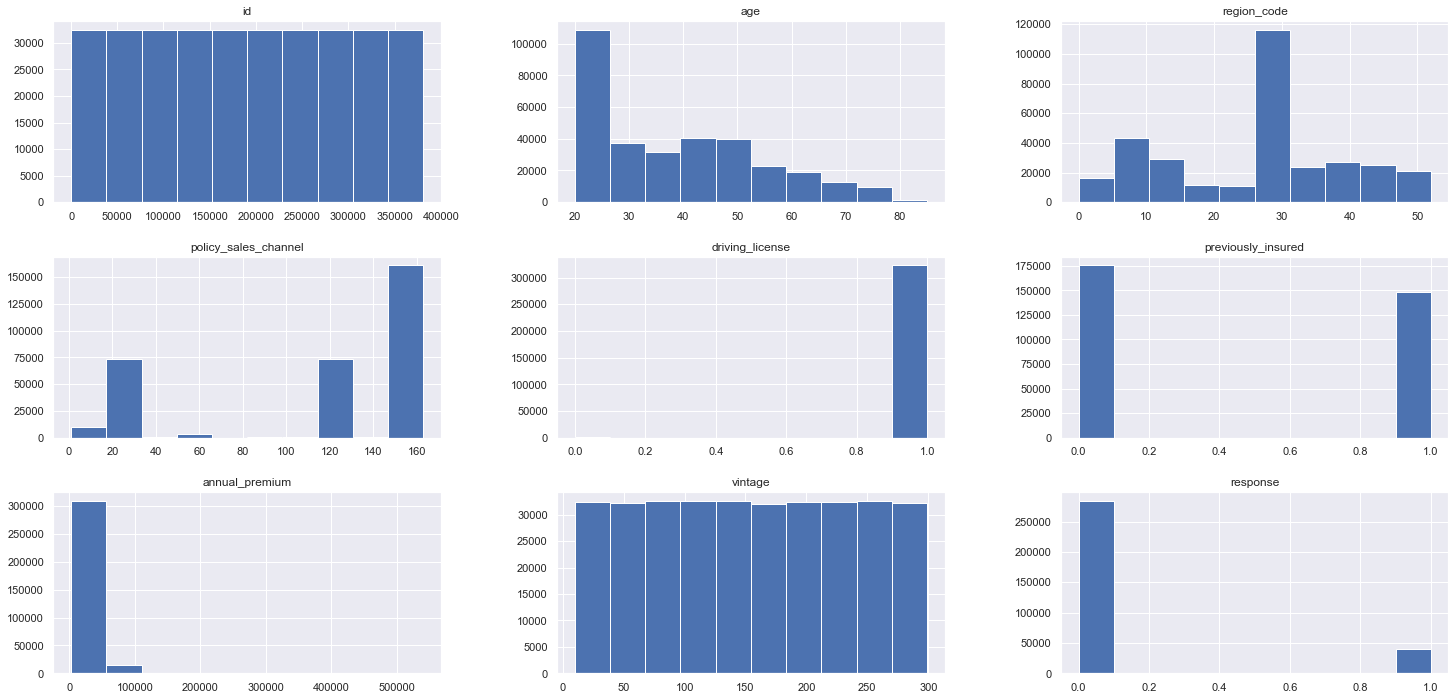

In [17]:
num_attributes.hist();

### 1.6.2 Categorical Attributes

In [18]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,323942,323942,323942
unique,2,3,2
top,Male,1-2 Year,Yes
freq,175248,170302,163516


# 2.0 Feature Engineering

In [19]:
df02 = df01.copy()

In [20]:
# Vehicle Damage Number
df02['vehicle_damage'] = df02['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# Vehicle Age
df02['vehicle_age'] =  df02['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# 3.0. Data Filtering

In [21]:
df03 = df02.copy()

# 4.0. Exploratoria Data Analysis

In [22]:
df04 = df03.copy()

## 4.1. Univariate Analysis

### 4.1.1 Age

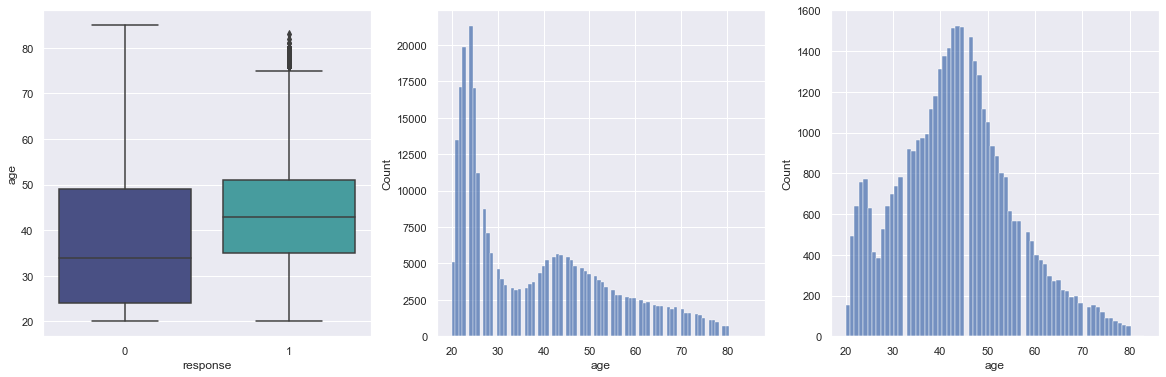

In [23]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='age', data=df04, palette='mako')

aux00 = df04.loc[df04['response'] == 0, 'age']
plt.subplot(1,3,2)
sns.histplot(aux00, palette='mako');

aux00 = df04.loc[df04['response'] == 1, 'age']
plt.subplot(1,3,3)
sns.histplot(aux00, palette='mako');

### 4.1.1.2 Anual Premium

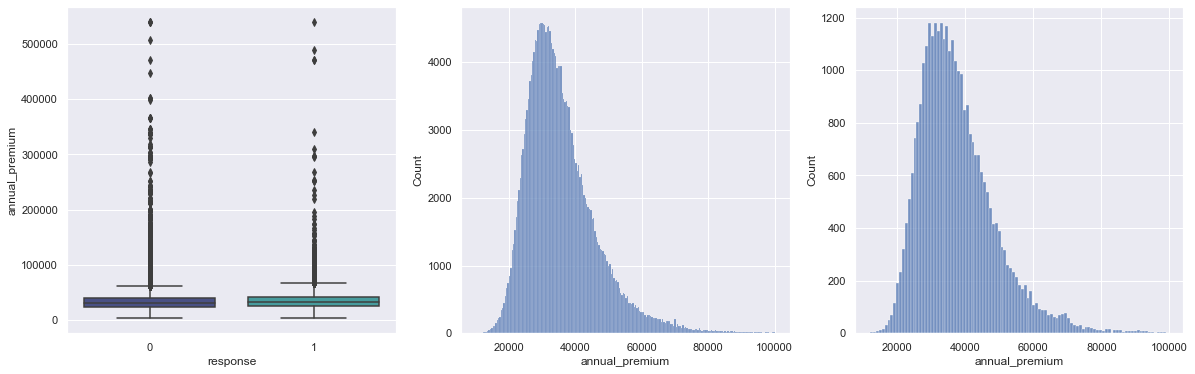

In [24]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='annual_premium', data=df04, palette='mako')

aux00 = df04[(df04['annual_premium'] > 10000) &(df04['annual_premium'] < 100000)]

aux01 = aux00.loc[aux00['response'] == 0, 'annual_premium']
plt.subplot(1,3,2)
sns.histplot(aux01, palette='mako');

aux01 = aux00.loc[aux00['response'] == 1, 'annual_premium']
plt.subplot(1,3,3)
sns.histplot(aux01, palette='mako');

### 4.1.3 Driving License

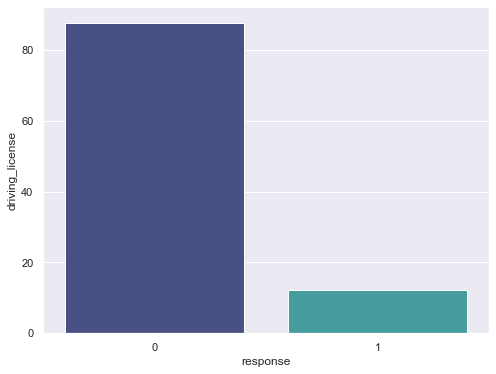

In [25]:
plt.figure(figsize=(8,6))

aux00 = df04[['driving_license', 'response']].groupby('response').sum().reset_index()
aux00['driving_license'] = (aux00['driving_license'] / aux00['driving_license'].sum())*100
sns.barplot(x='response', y='driving_license', data=aux00, palette='mako');

### 4.1.4. Region Code

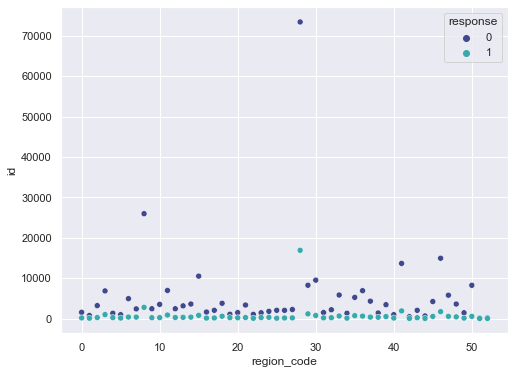

In [26]:
plt.figure(figsize=(8,6))

aux00 = df04[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code', y='id', hue='response', data=aux00, palette='mako');

### 4.1.5. Previously Insured

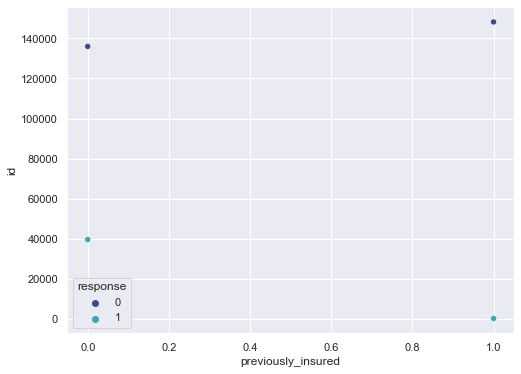

In [27]:
plt.figure(figsize=(8,6))

aux00 = df04[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()

sns.scatterplot(x='previously_insured', y='id', hue='response', data=aux00, palette='mako');

In [28]:
pd.crosstab(df04['previously_insured'], df04['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774607,0.225393
1,0.999137,0.000863


### 4.1.6. Vehicle Age

In [29]:
df04[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,133926
1,below_1_year,1,6098
2,between_1_2_year,0,140724
3,between_1_2_year,1,29578
4,over_2_years,0,9589
5,over_2_years,1,4027


### 4.1.7. Vehicle Damage

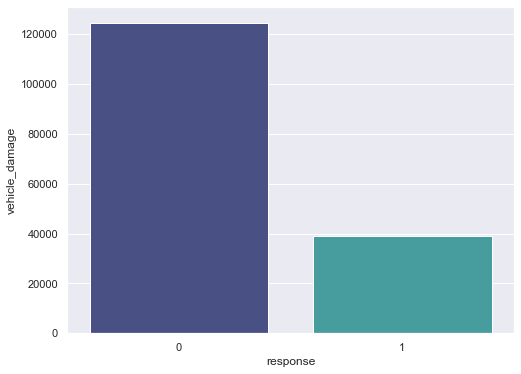

In [30]:
plt.figure(figsize=(8,6))

aux00 = df04[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='vehicle_damage', data=aux00, palette='mako');

###  4.1.8. Policy Sales Channel - Stacked Percentage Bar

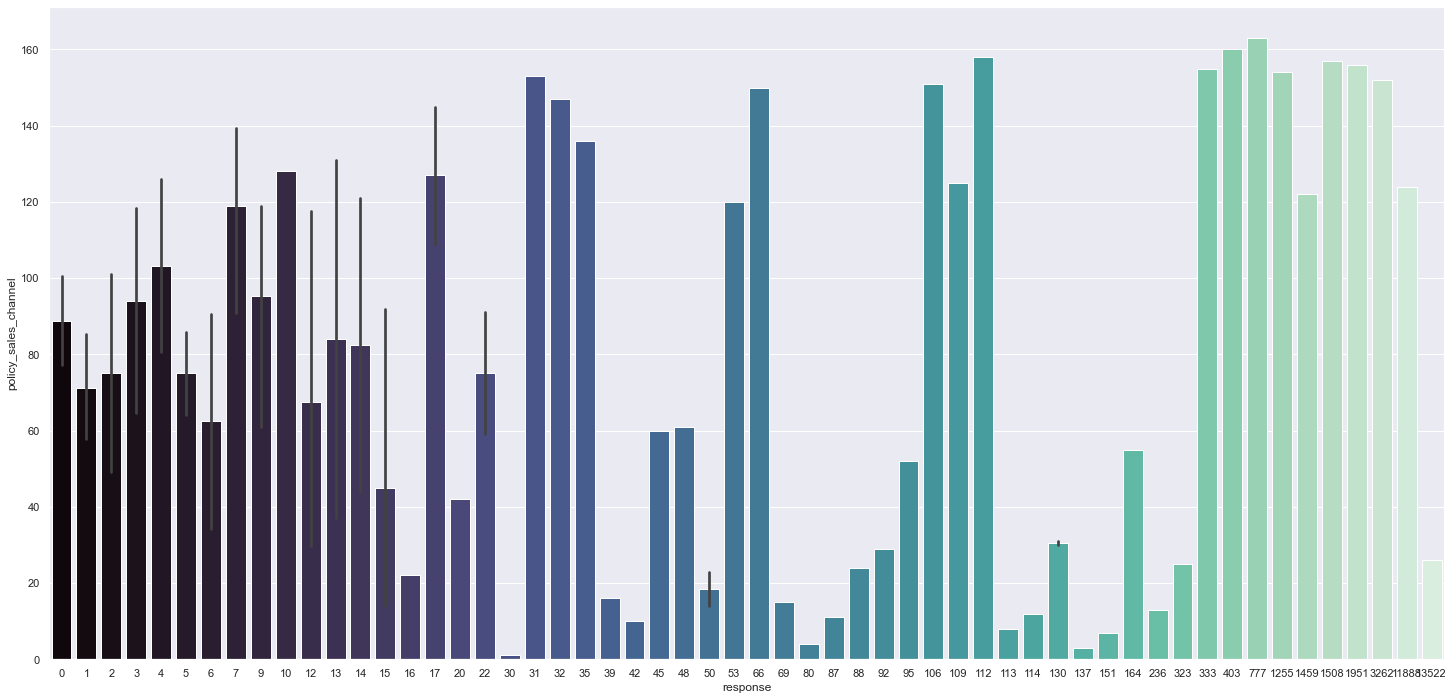

In [31]:
aux00 = df04[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux00, palette='mako');

### 4.1.9. Vintage

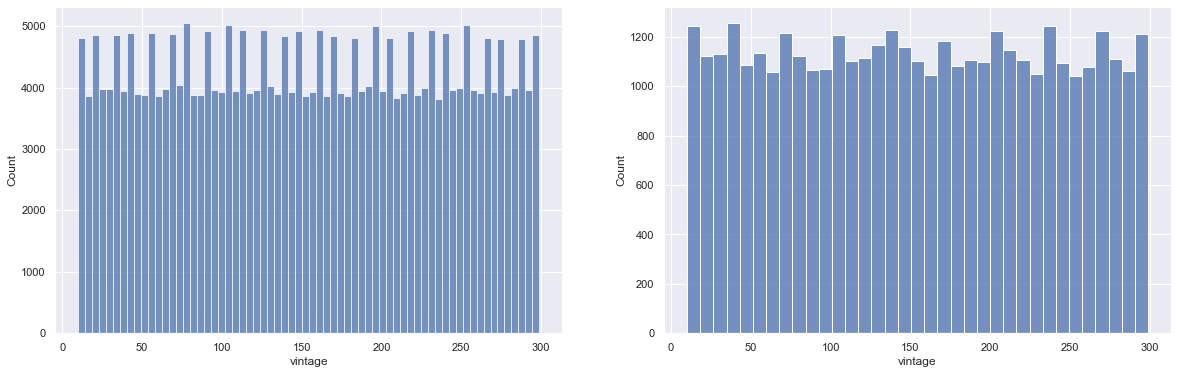

In [32]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
aux00 = df04.loc[df04['response'] == 0, 'vintage']
sns.histplot(aux00, palette='mako');

plt.subplot(1,2,2)
aux00 = df04.loc[df04['response'] == 1, 'vintage']
sns.histplot(aux00, palette='mako');

## 4.3 Multivariable analysis (Balanced Dataset)

In [33]:
cat_cols = ['region_code', 'policy_sales_channel', 'driving_license', 'vehicle_damage']

num_attributes = df04.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(cat_cols, axis=1)

cat_attributes = df04.select_dtypes(exclude=['int64', 'float64'])
cat_attributes_list = cat_attributes.columns.tolist()
cat_attributes_list.extend(cat_cols)
cat_attributes = df04[cat_attributes_list]

### 4.3.1 Numerical

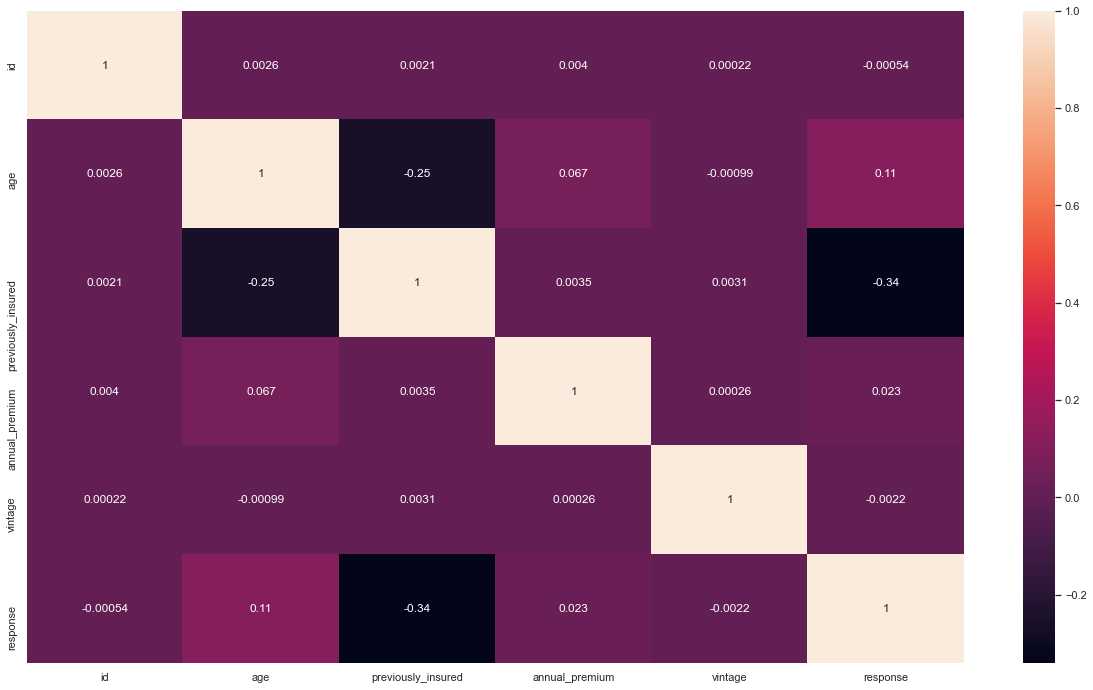

In [34]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical

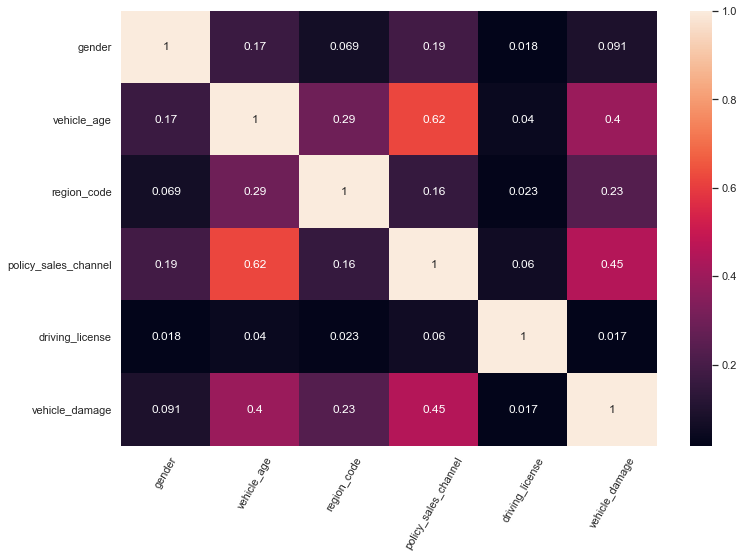

In [35]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
plt.figure(figsize=(12,8))
sns.heatmap(d, annot=True);
plt.xticks(rotation=60);

# 5.0. Data Preparation

In [36]:
X = df04.drop( 'response', axis=1)
y = df04['response'].copy() 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

df05 = pd.concat([X_train, y_train], axis=1)

## 5.1. Standardization

In [37]:
ss = StandardScaler()

# anual premium - StandarScaler
df05['annual_premium'] = ss.fit_transform( df05[['annual_premium']].values )

## 5.2. Rescaling

In [39]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# Age - MinMaxScaler
df05['age'] = mms_age.fit_transform( df05[['age']].values )

# Vintage - MinMaxScaler
df05['vintage'] = mms_vintage.fit_transform( df05[['vintage']].values )

## 5.3. Transformation

In [40]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df05.groupby('gender')['response'].mean()
df05.loc[:, 'gender'] = df05['gender'].map(target_encode_gender)

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df05.groupby('region_code')['response'].mean()
df05.loc[:, 'region_code'] = df05['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding / Frequency Encoding
df05 = pd.get_dummies(df05, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df05.groupby('policy_sales_channel').size() / len(df05) 
df05.loc[:, 'policy_sales_channel'] = df05['policy_sales_channel'].map(fe_policy_sales_channel)

## 5.4. Validation Preparation

In [41]:
# gender
X_val.loc[:, 'gender'] =  X_val.loc[:, 'gender'].map(target_encode_gender)

# age
X_val.loc[:, 'age'] = mms_age.transform(X_val[['age']].values)

# region_code
X_val.loc[:, 'region_code'] = X_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
X_val = pd.get_dummies(X_val, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
X_val.loc[:, 'annual_premium'] = ss.transform(X_val[['annual_premium']].values)

# policy_sales_channel
X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
X_val.loc[:, 'vintage'] = mms_vintage.transform(X_val[['vintage']].values)

# fillna
X_val = X_val.fillna(0)

#  6.0. Feature Selection

##  6.1. Boruta Algorithm

In [45]:
X_train_n = df05.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# Define model
et = ExtraTreesClassifier(n_jobs=-1)

# Define boruta
boruta = BorutaPy(et, n_estimators='auto', verbose=2, random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

BorutaPy(estimator=ExtraTreesClassifier(n_estimators=20, n_jobs=-1,
                                        random_state=RandomState(MT19937) at 0x1896D555140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1896D555140, verbose=2)

In [49]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = df05.drop(['id', 'response'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['age']

## 6.2. Feature Importance

In [47]:
# model definition
forest = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
X_train_n = df05.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.270640
0                annual_premium    0.241627
0                           age    0.168120
0                   region_code    0.106803
0                vehicle_damage    0.067267
0          policy_sales_channel    0.060471
0            previously_insured    0.055923
0      vehicle_age_below_1_year    0.014265
0  vehicle_age_between_1_2_year    0.006392
0                        gender    0.005447
0      vehicle_age_over_2_years    0.002510
0               driving_license    0.000536


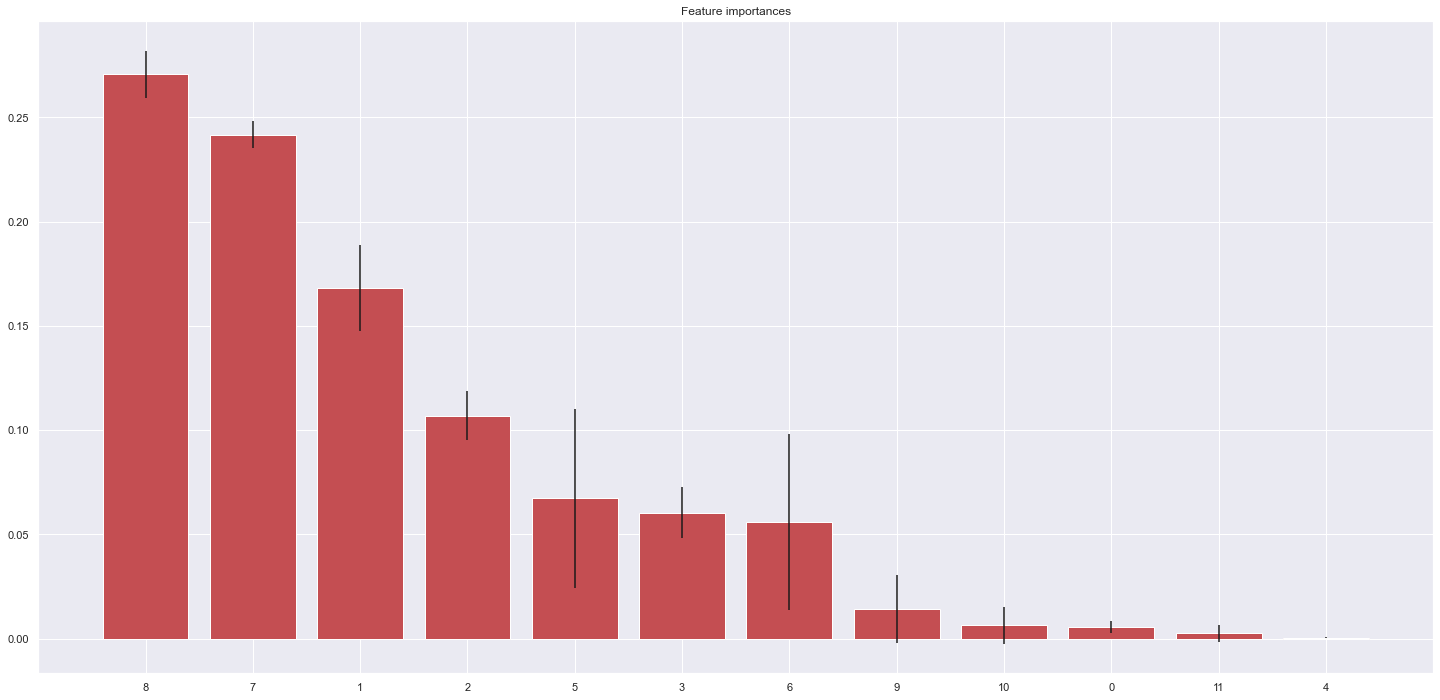

In [48]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( X_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [50]:
 cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [51]:
X_train = df05[cols_selected]
X_val = X_val[cols_selected]

## 7.1. KNN Classifier

In [54]:
# model definition
knn_model = KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(X_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(X_val)

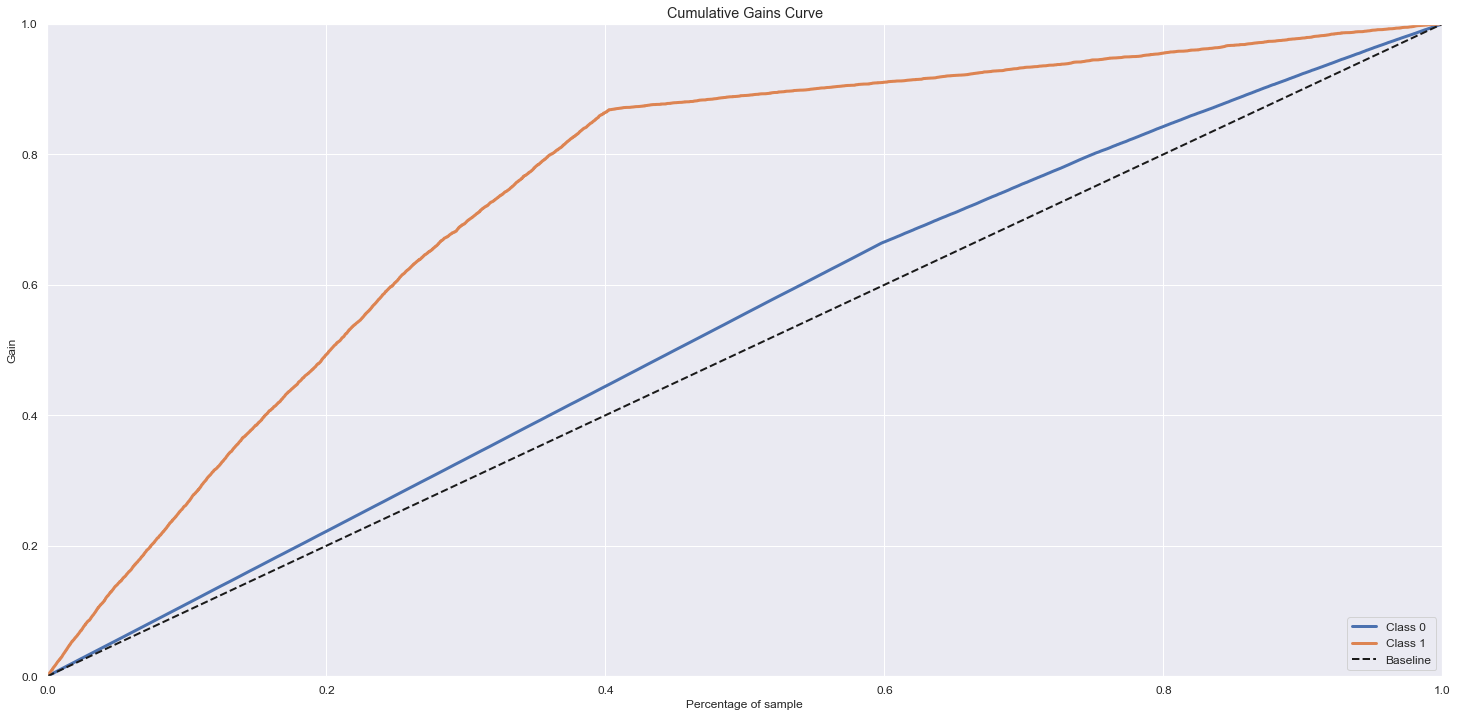

In [56]:
 # Accumulative Gain
plot_cumulative_gain( y_val, yhat_knn );

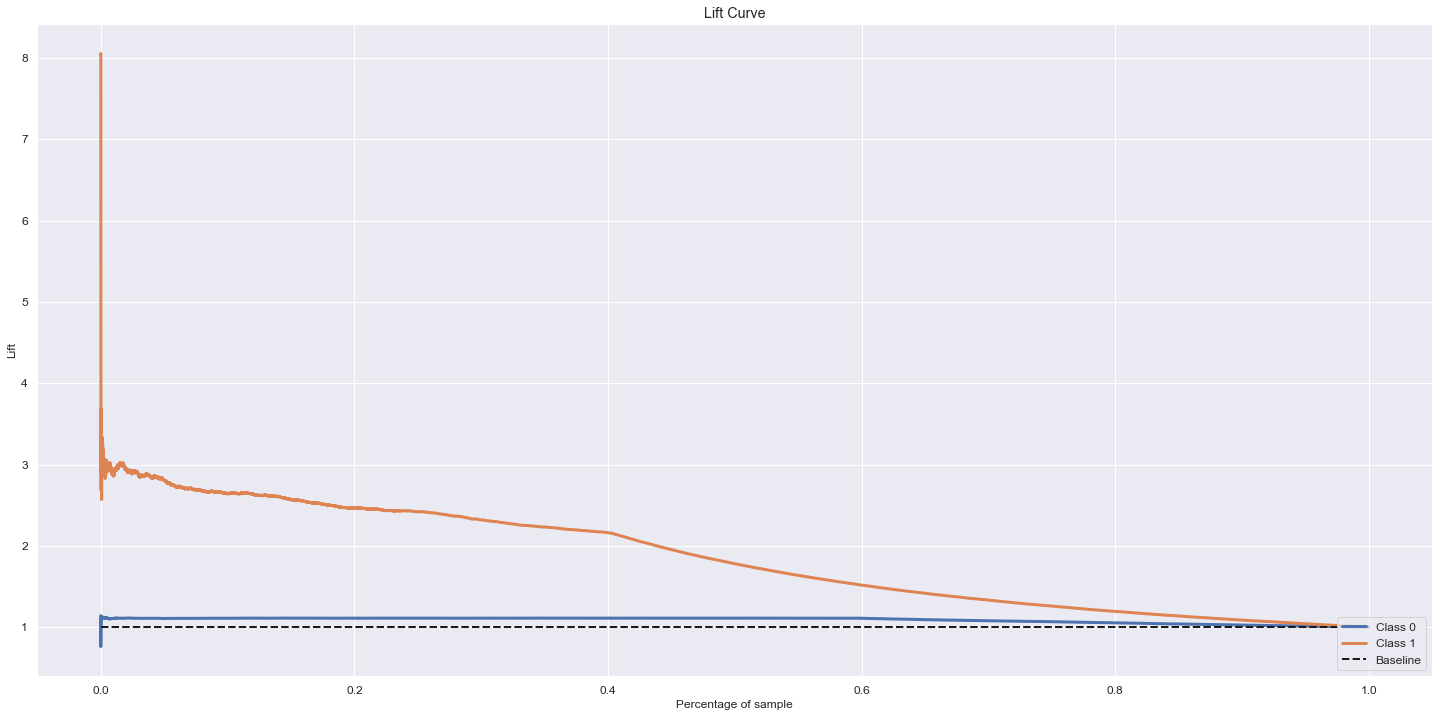

In [57]:
 #Scikitplot library is there to help
plot_lift_curve( y_val, yhat_knn );

## 7.2. Logistic Regression

In [61]:
# model definition
lr_model = LogisticRegression(random_state=42) 

# model training
lr_model.fit(X_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(X_val)

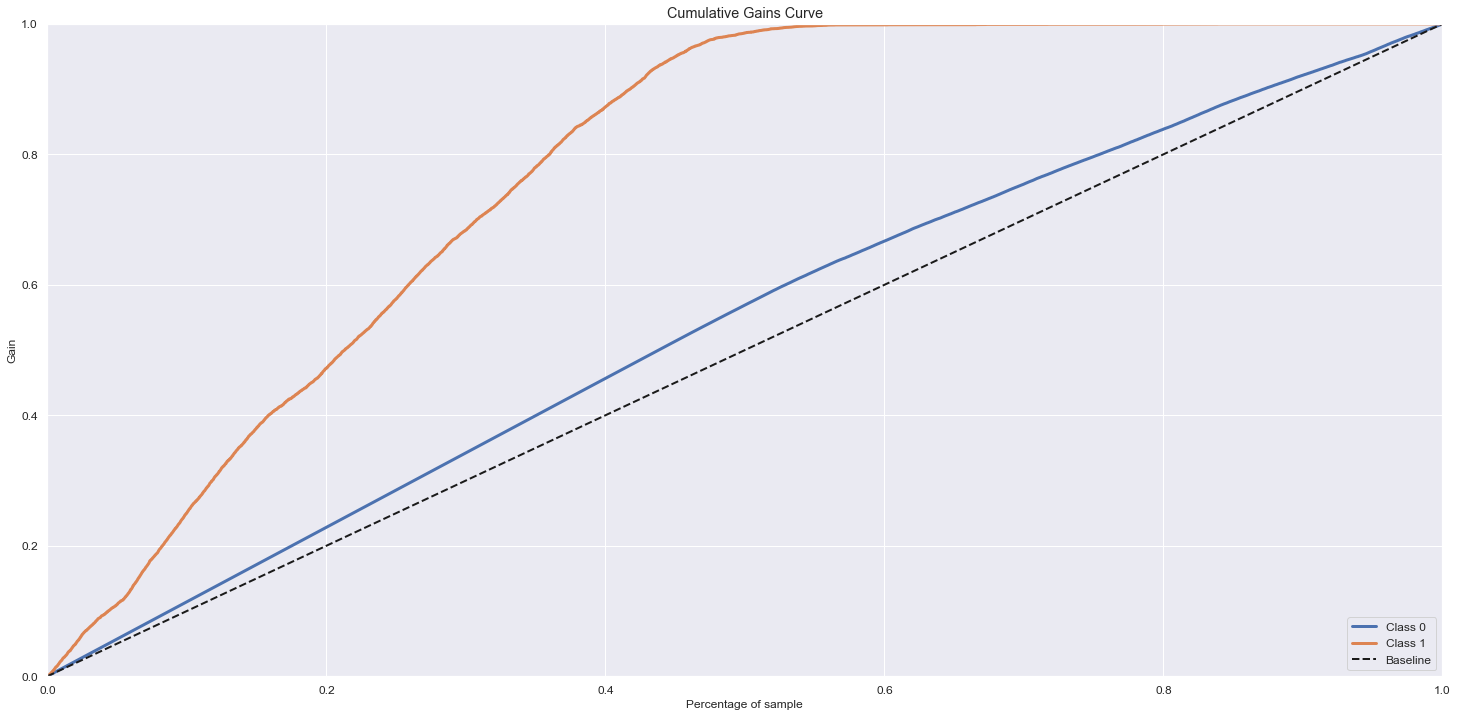

In [62]:
# Accumulative Gain
plot_cumulative_gain(y_val, yhat_lr);

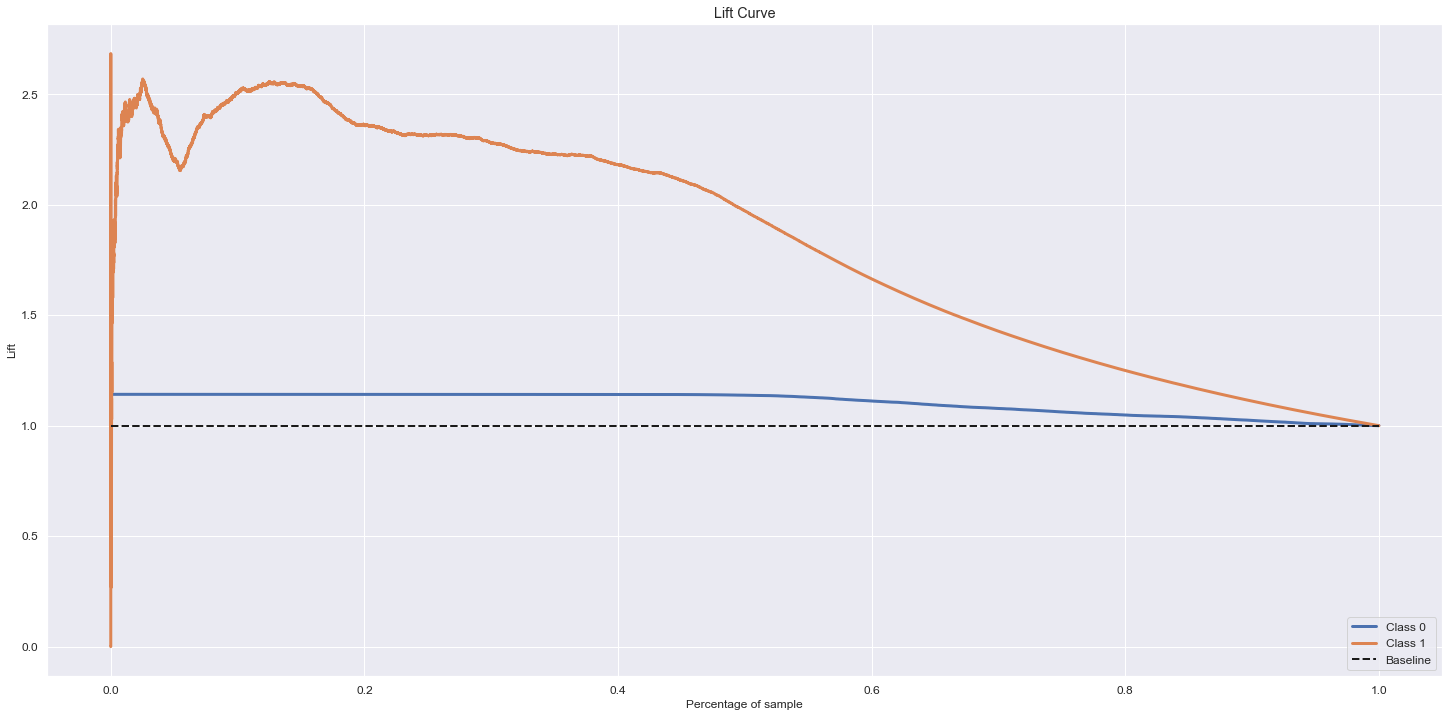

In [63]:
 #Scikitplot library is there to help
plot_lift_curve(y_val, yhat_lr);

 ## 7.3. Extra Trees Classifier

In [64]:
# model definition
et = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# model training
et.fit(X_train, y_train)

# model prediction
yhat_et = et.predict_proba(X_val)

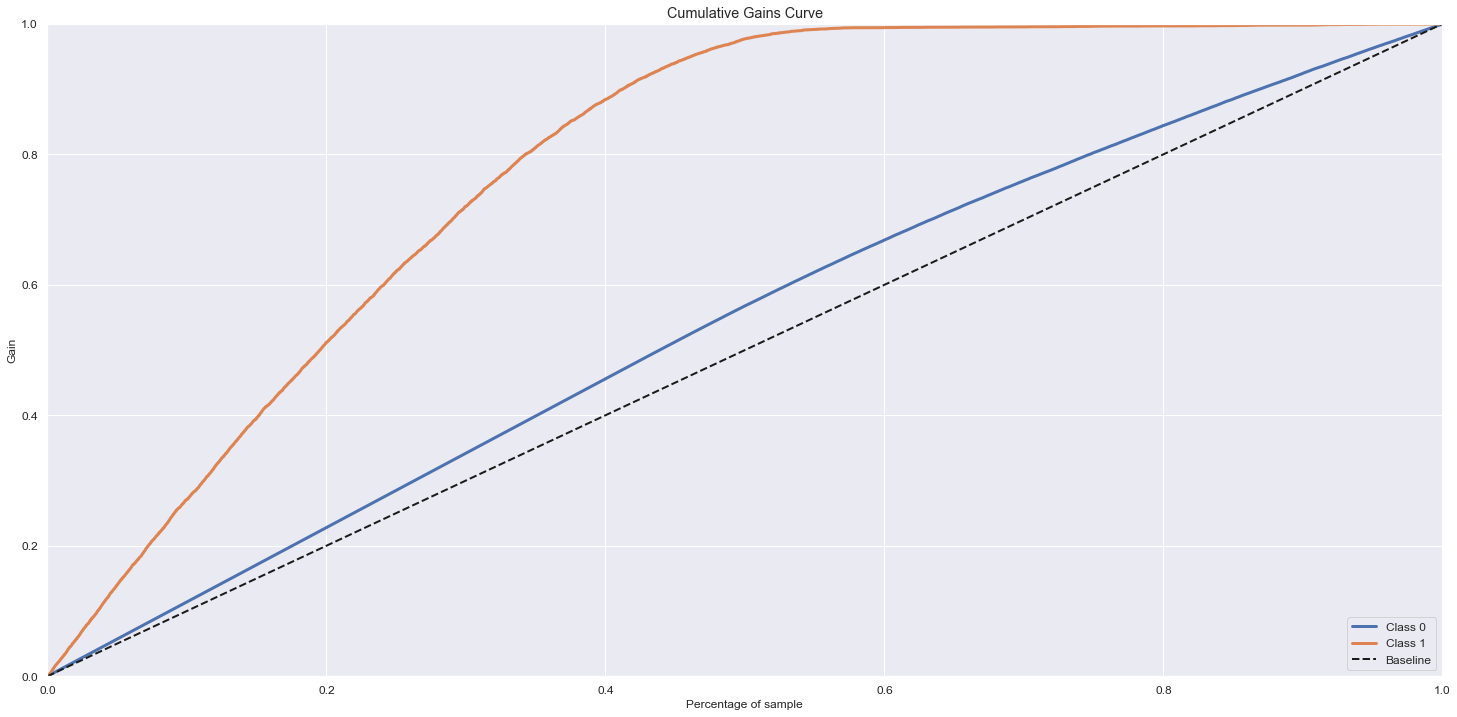

In [65]:
 # Accumulative Gain
plot_cumulative_gain(y_val, yhat_et);

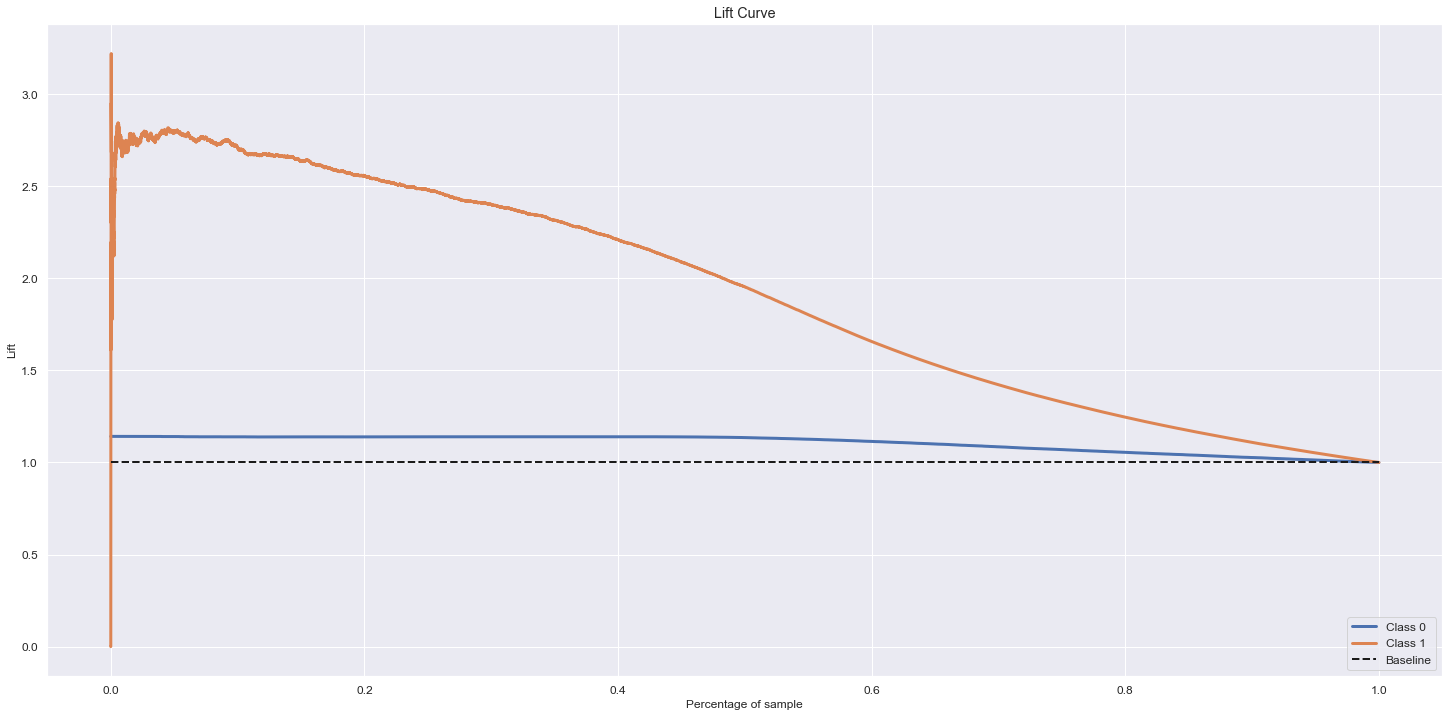

In [66]:
#Scikitplot library is there to help
plot_lift_curve(y_val, yhat_et);

## 7.4. Random Forest

In [69]:
# model definition
rf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42) 

# model training
rf.fit(X_train, y_train)

# model prediction
yhat_rf = rf.predict_proba(X_val)

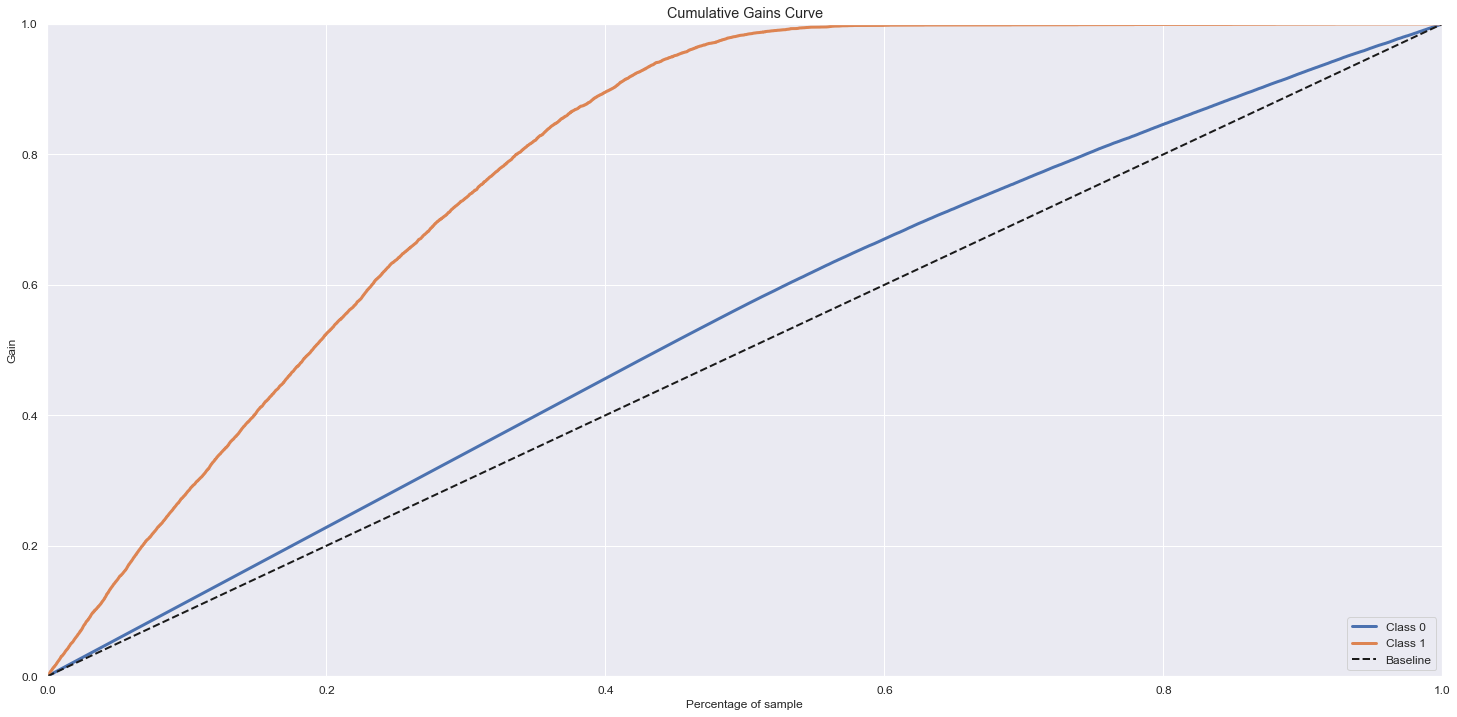

In [70]:
# Accumulative Gain
plot_cumulative_gain(y_val, yhat_rf);

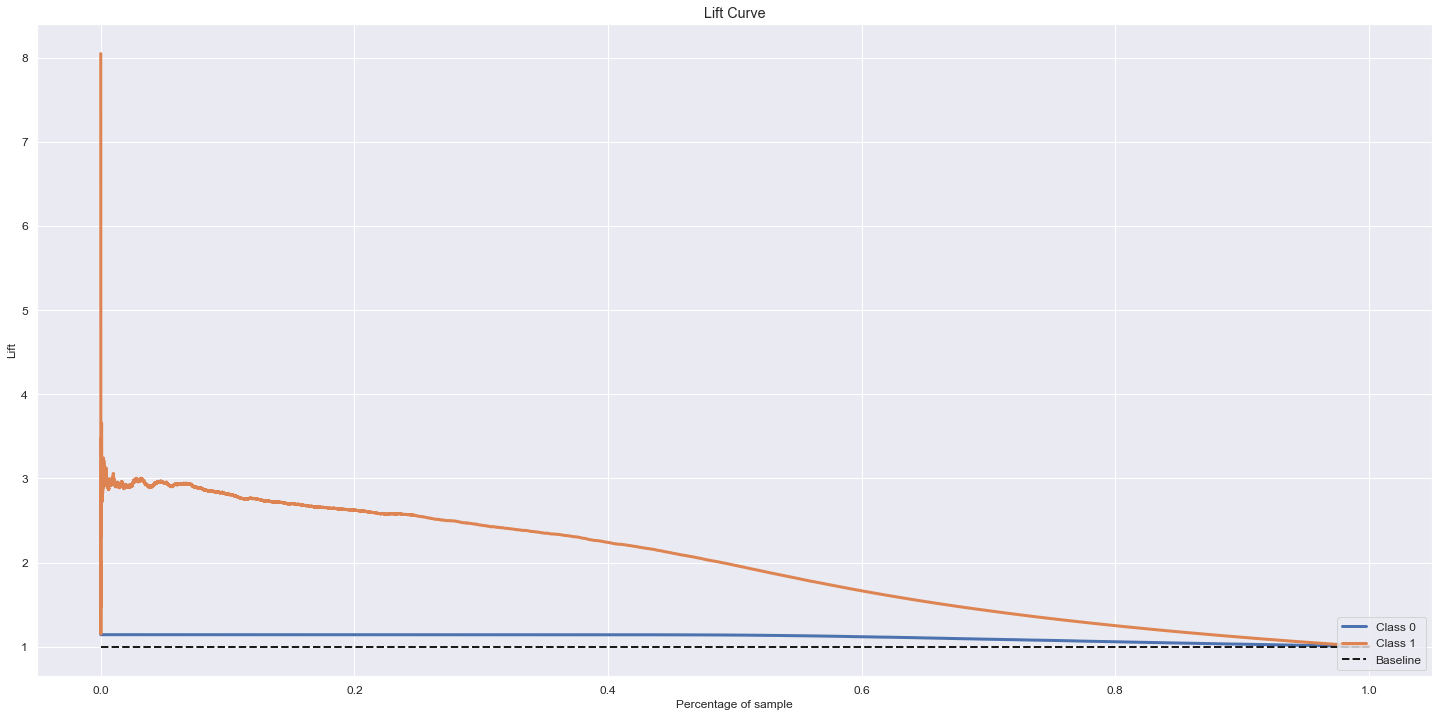

In [71]:
 #Scikitplot library is there to help
plot_lift_curve(y_val, yhat_rf);